# Recommendations with IBM

This notebook creates a recommendation system using data from the IBM Watson Studio platform. 

There are two sources of data:

1. user-item-interactions.csv - data of all user-article interactions
2. articles_community.csv - article descriptions

The goal of this notebook is to explore collaborative based filtering using user-user similarity as well as matrix factorization methods




## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# Import raw data
df = pd.read_csv('./user-item-interactions.csv')
df_content = pd.read_csv('./articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

print(df.head())
print(df_content.head())

   article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2  
                                            doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  ☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLo

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


        article_id        title
count  5148.000000  5148.000000
mean      8.930847     8.930847
std      16.802267    16.802267
min       1.000000     1.000000
25%       1.000000     1.000000
50%       3.000000     3.000000
75%       9.000000     9.000000
max     364.000000   364.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DE3DD58E20>,
      dtype=object)

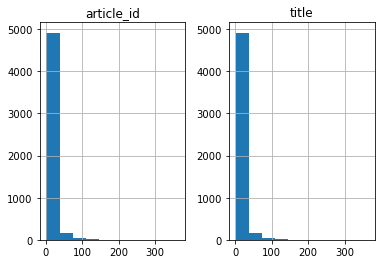

In [5]:
# Count number of item interactions by user email

interaction_counts = df.groupby('email').count()
print(interaction_counts.describe())
interaction_counts.hist()

In [6]:
# Find duplicate article ids
df_content[df_content.duplicated(subset = 'article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = 'article_id')

In [8]:
#Basic user/article descriptive statistics
n_articles_interactions = df['article_id'].unique()
print("N Unique Articles w/ Interaction: {0}".format(len(n_articles_interactions)))

n_articles = df_content['article_id'].unique()
print("N Unique Articles: {0}".format(len(n_articles)))

n_users = df['email'].dropna().unique()
print("N Unique Users: {0}".format(len(n_users)))

interactions = df.shape[0]
print("N Interactions: {0}".format(interactions))

N Unique Articles w/ Interaction: 714
N Unique Articles: 1051
N Unique Users: 5148
N Interactions: 45993


In [9]:
# Find most viewed article ID by counting interactions
df.groupby('article_id').count().sort_values('email', ascending = False).iloc[0, :]

title    937
email    937
Name: 1429.0, dtype: int64

In [10]:
# Create user email to unique user-id mapping

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Here we create utilities to output the top ranked articles by number of interactions

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('title').count().sort_values('article_id', ascending = False).index[0:n]
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').count().sort_values('title', ascending = False).index[0:n]
 
    return top_articles # Return the top article ids

In [13]:
# function testing
print(get_top_articles(5))
print(get_top_articles(10))
print(get_top_articles(20))



Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm'],
      dtype='object', name='title')
Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
Index(['use deep learning for image classification',
       'insight

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


Make recommendations based on similarity between how users interacted with articles in the past. The algorithm is as follows:

1. Create user-item matrix to record which articles each user interacted with
2. Rank order users by similarity to target user
3. Find list of top articles read by similar users
4. Recommend the top K

In [14]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df = df.drop_duplicates(['user_id', 'article_id']).drop(columns = 'title')
    df["interaction"] = 1
    
    user_item = df.pivot(index = 'user_id', columns = 'article_id', values = 'interaction')
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [15]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    # compute similarity of each user to the provided user
    user_sims = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    user_sims = user_sims.sort_values(ascending = False)

    # create list of just the ids
    sim_ids = user_sims.index
   
    # remove the own user's id
    most_similar_users = sim_ids[sim_ids != user_id]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
# testing
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Int64Index([3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Int64Index([1, 23, 3782, 4459, 203], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Int64Index([4201, 23, 3782], dtype='int64', name='user_id')


In [17]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str))
    article_names = list(get_article_names(article_ids, df))
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    closest_users = find_similar_users(user_id, user_item)
    target_articles = get_user_articles(user_id, user_item)

    for sim_user in closest_users:
        sim_user_articles = get_user_articles(sim_user, user_item)
        
        recs.extend(list(set(sim_user_articles[0]).difference(set(target_articles[0]))))
        
        if len(recs) >= m:
            break
    
    recs = recs[0:m]
   
    return recs 

In [19]:
# testing
get_article_names(user_user_recs(1, 10))

array(['the unit commitment problem',
       'apache spark lab, part 3: machine learning',
       'better together: spss and data science experience',
       'shaping data with ibm data refinery',
       'variational auto-encoder for "frey faces" using keras',
       '5 practical use cases of social network analytics: going beyond facebook and twitter',
       'brunel interactive visualizations in jupyter notebooks',
       'this week in data science (april 18, 2017)',
       'using rstudio in ibm data science experience',
       'get started with streams designer by following this roadmap'],
      dtype=object)

The two function below improve robustness by making the following changes: 

* Choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Choose articles with the articles with the most total interactions before choosing those with fewer total interactions

In [20]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # calculate total interactions by user
    user_interactions = df['user_id'].value_counts()
    
    # compute similarity of each user to the provided user
    user_sims = user_item.dot(user_item.loc[user_id])

    # sort by similarity then volume  
    neighbors_df = pd.DataFrame(data = {'similarity': user_sims, 
                                        "num_interactions": user_interactions})
    neighbors_df = neighbors_df.sort_values(["similarity", "num_interactions"], ascending = [False, False])
       
    # remove the own user's id
    neighbors_df = neighbors_df[neighbors_df.index != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    closest_users = get_top_sorted_users(user_id, df, user_item)
    target_articles = get_user_articles(user_id, user_item)

    for sim_user in closest_users.index:
        #sim_user_articles = get_user_articles(sim_user, user_item)
        sim_user_articles = get_top_article_ids(m, df=df[df['user_id'] == sim_user])
        
        recs.extend(list(set(sim_user_articles).difference(set(target_articles[0]))))
        
        if len(recs) >= m:
            break
    
    recs = recs[0:m]
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names

In [21]:
# testing
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[362.0, 1360.0, 1329.0, 1330.0, 1427.0, 1172.0, 1170.0, 793.0, 1276.0, 1278.0]

The top 10 recommendations for user 20 are the following article names:
['deploy your python model as a restful api'
 'apache spark lab, part 1: basic concepts' 'dsx: hybrid mode'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'apache spark lab, part 3: machine learning'
 'insights from new york car accident reports'
 'pixieapp for outlier detection'
 '10 powerful features on watson data platform, no coding necessary'
 'ingest data from message hub in a streams flow'
 'develop a scala spark model on chicago building violations']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

This part of the notebook tests latent factor models using SVD. The algorithm is as follows:

1. Perform SVD with different values of K 
2. Choose K by testing performence on held out test dataset

In [22]:
# Load matrix from above
user_item_matrix = pd.read_pickle('user_item_matrix.p')
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Perform SVD 
u, s, vt = np.linalg.svd(user_item_matrix) 

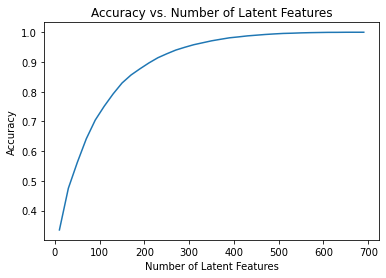

In [24]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [25]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [26]:
print("User Item Train Shape: {0}".format(user_item_train.shape))
print("User Item Test Shape: {0}".format(user_item_test.shape))
print("Train/Test User Overlap:{0}".format(test_idx.isin(user_item_train.index).sum()))
print("Train/Test Article Overlap:{0}".format(test_arts.isin(user_item_train.columns).sum()))


User Item Train Shape: (4487, 714)
User Item Test Shape: (682, 574)
Train/Test User Overlap:20
Train/Test Article Overlap:574


In [27]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

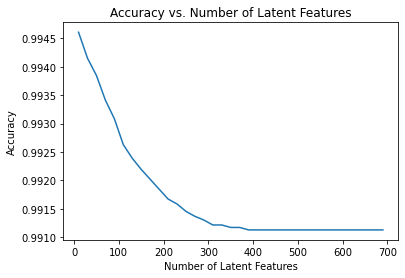

In [28]:
# Can only predict on common users/items between train and test
# Create IDX boolean arrays to subset matrices when calculating error

train_row_idx = user_item_train.index.isin(user_item_test.index)
train_col_idx = user_item_train.columns.isin(user_item_test.columns)
test_row_idx = user_item_test.index.isin(user_item_train.index)
test_col_idx = user_item_test.columns.isin(user_item_train.columns)


num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.values[test_row_idx, :][:, test_col_idx], 
                        user_item_est[train_row_idx, :][:, train_col_idx])
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

**The negative correlation between accuracy and number of features suggests that the model is overfit to the training data because of the small overlap between training and test users. To better evaluate the recommendation system performance, I would design an A/B test where a random percentage of the population would recieve recommendations from the model and measure the difference in pageviews between the two groups**